# An approach using different kinds of Regressors

The idea of this notebook is to show you an approach making use of different regressors which are:

* XGBoosting
* Random Forest
* Gradient Boosting Tree
* Ada Boost Regressor

In this notebook we compare the performance of each regressor making a variation in the number of estimator for each regressor.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
% matplotlib inline

# 1. Preparing dataset

For this exercise, we will only load a million of samples. The original dataset is like 2GB of samples which is so much for my computer, so loading only a million is enoguh for this example.

In [2]:
data = pd.read_csv('train.csv', nrows=100000)

Next we will to describe the dataframe to look some interesting things.

In [3]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,11.354652,-72.494682,39.914481,-72.490967,39.919053,1.673820
std,9.716777,10.693934,6.225686,10.471386,6.213427,1.300171
min,-44.900000,-736.550000,-74.007670,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992041,40.734996,-73.991215,40.734182,1.000000
50%,8.500000,-73.981789,40.752765,-73.980000,40.753243,1.000000
75%,12.500000,-73.966982,40.767258,-73.963433,40.768166,2.000000
max,200.000000,40.787575,401.083332,40.851027,404.616667,6.000000


Some important things we can notice is that the average fare is something like 11.3. Another important think is that the standard deviation in either pickup and dropoff longitud is similar as well as pickup and dropoff latitude.
We can see that there are some null values, we will proceed to fix it.

## 1.1 Removing null values

In [4]:
data.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [5]:
print('Size with nulls (train): %d' % len(data))
data = data.dropna(how = 'any', axis = 'rows')
print('Size without nulls (train): %d' % len(data))

Size with nulls (train): 100000
Size without nulls (train): 100000


## 1.1 Removing fake fares

One important thing is analyze if the dataset have noise. In this case we are goint to look if there are some "fake" fares. For this case we will accept as a "fake" value every sample minor than zero from the fares_amount column, this is because it could not be negative values for this column.

In [6]:
k = 0
for i in data.fare_amount:
    if i < 0:
        k += 1
print("Number of fake fares: ", k)

Number of fake fares:  9


There are 38 values which are under 0, this is not possible due to the fare must be more than zero. So, we will to proceed to remove all these values.

In [7]:
print('Length of original data: %d' % len(data))
data = data[data.fare_amount>=0]
print('Lengh of new data: %d' % len(data))

Length of original data: 100000
Lengh of new data: 99991


# 2. Visualization

Always is important to visualizate data, so in this part we are going to go deeper inside dataset for a better understanding.

## 2.1 Histogram of fare amount

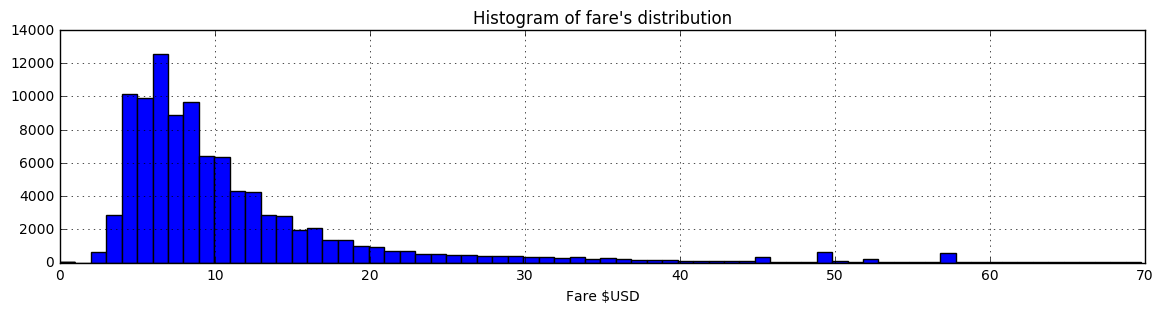

In [8]:
data[data.fare_amount<70].fare_amount.hist(bins=70, figsize=(14,3))
plt.xlabel('Fare $USD')
plt.title("Histogram of fare's distribution");

It is obvious that the fare amount are centered around 8usd. Also we can see that there are some extra points with fares so expensive, this is more than 45usd.

# 3. Adding new features

The orginal dataset is composed with the next features:

* fare_amount	
* pickup_longitude	
* pickup_latitude	
* dropoff_longitude	
* dropoff_latitude	
* passenger_count

which are the basic atributes to describe the behavior of the pickup and dropoff process. But, are all of these values important? do we could add some more features to the dataset? which? how?.
Well, it is important to notice that we could add more features from the dataset, for example the distance between the pickup and dropoff a customer. So, based in this idea we will proceed to add this features to the dataset.

In [9]:
data['lon_change'] = abs(data.dropoff_longitude - data.pickup_longitude)
data['lat_change'] = abs(data.dropoff_latitude - data.pickup_latitude)

features_train  = ['pickup_longitude',
               'pickup_latitude',
               'dropoff_longitude',
               'dropoff_latitude',
               'lat_change',
               'lon_change']

In [10]:
Y = data.fare_amount
X = data[features_train]

In [11]:
X.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,lat_change,lon_change
0,-73.844311,40.721319,-73.841610,40.712278,0.009041,0.002701
1,-74.016048,40.711303,-73.979268,40.782004,0.070701,0.036780
2,-73.982738,40.761270,-73.991242,40.750562,0.010708,0.008504
3,-73.987130,40.733143,-73.991567,40.758092,0.024949,0.004437
4,-73.968095,40.768008,-73.956655,40.783762,0.015754,0.011440


## 3.1 Scaling the Y vector

The target (Y) vector has values bigger than zero, for simplicity we will scale it in a range of 0,1.

In [12]:
min_max_scaler = preprocessing.MinMaxScaler()
Y = min_max_scaler.fit_transform(Y)

/Users/Fer/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/Fer/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


## 3.2 Splitting data

In [13]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.33, random_state=42)

In [14]:
np.save('Xtrain.npy',Xtrain)
np.save('Xtest.npy', Xtest)
np.save('Ytrain.npy', Ytrain)
np.save('Ytest.npy', Ytest)

# 4. Regression modules

In [15]:
class Regressors:
    def __init__(self, Xtrain, Xtest, Ytrain, Ytest):
        self.Xtrain = Xtrain
        self.Xtest = Xtest
        self.Ytrain = Ytrain
        self.Ytest = Ytest

    def def_xgboost(self, estimators):
        xgb_ = xgb.XGBRegressor(objective ='reg:linear', learning_rate=0.01, max_depth=3, n_estimators=estimators)
        xgb_.fit(self.Xtrain, self.Ytrain)
        pred = xgb_.predict(self.Xtest)
        
        return pred

    def def_RandomForestRegressor(self, estimators):
        rfr_ = RandomForestRegressor(n_estimators=estimators, max_depth=3)
        rfr_.fit(self.Xtrain, self.Ytrain)
        pred = rfr_.predict(self.Xtest)

        return pred

    def def_GradientBoostingRegressor(self, estimators):
        gbr_ = GradientBoostingRegressor(n_estimators=estimators, max_depth=3)
        gbr_.fit(self.Xtrain, self.Ytrain)
        pred = gbr_.predict(self.Xtest)

        return pred

    def def_AdaBoostRegressor(self, estimators):
        abr_ = AdaBoostRegressor(n_estimators=estimators)
        abr_.fit(self.Xtrain, self.Ytrain)
        pred = abr_.predict(self.Xtest)

        return pred

In [16]:
def def_metrics(ypred):
    mae = mean_absolute_error(Ytest, ypred)
    mse = mean_squared_error(Ytest, ypred)

    return mae, mse

def plot_performance(plot_name, loss_mae, loss_mse):
    steps = np.arange(50, 500, 50)
    plt.style.use('ggplot')
    plt.title(plot_name)
    plt.plot(steps, loss_mae, linewidth=3, label="MAE")
    plt.plot(steps, loss_mse, linewidth=3, label="MSE")
    plt.legend()
    plt.ylabel("Loss")
    plt.xlabel("Number of estimators")
    plt.show()

In [17]:
model = Regressors(Xtrain, Xtest, Ytrain, Ytest)

## 4.2 XGBoost

XGBoosting Regressor
Number of estimators: 50
MAE:  0.268556920268
MSE:  0.0732754324612
Number of estimators: 100
MAE:  0.163131052904
MSE:  0.0272683219257
Number of estimators: 150
MAE:  0.0997055884581
MSE:  0.0103993594303
Number of estimators: 200
MAE:  0.061763787024
MSE:  0.00420553552461
Number of estimators: 250
MAE:  0.0394233414477
MSE:  0.00191993745602
Number of estimators: 300
MAE:  0.0266204181821
MSE:  0.00107334558997
Number of estimators: 350
MAE:  0.0196005278404
MSE:  0.000758506898203
Number of estimators: 400
MAE:  0.0159180821829
MSE:  0.000637746477729
Number of estimators: 450
MAE:  0.0140621869606
MSE:  0.000591850428458


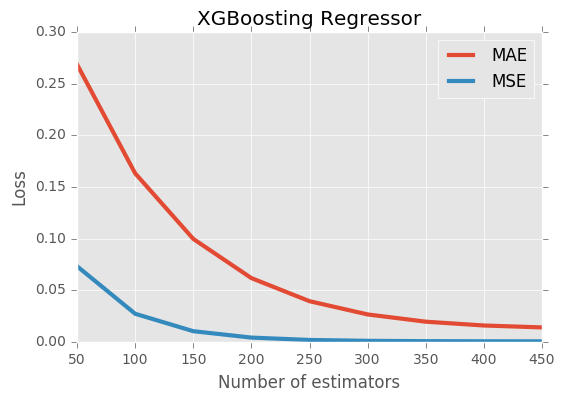

In [20]:
plot_name="XGBoosting Regressor"
loss_mae, loss_mse = [], []
print(plot_name)
for est in range(50,500,50):
    print("Number of estimators: %d" % est)
    mae, mse = def_metrics(model.def_xgboost(estimators = est))
    print("MAE: ", mae)
    print("MSE: ", mse)
    loss_mae.append(mae)
    loss_mse.append(mse)
plot_performance(plot_name, loss_mae, loss_mse)

## 4.2 Random Forest Regressor

Random Forest Regressor
Number of estimators: 50
MAE:  0.268556920268
MSE:  0.0732754324612
Number of estimators: 100
MAE:  0.163131052904
MSE:  0.0272683219257
Number of estimators: 150
MAE:  0.0997055884581
MSE:  0.0103993594303
Number of estimators: 200
MAE:  0.061763787024
MSE:  0.00420553552461
Number of estimators: 250
MAE:  0.0394233414477
MSE:  0.00191993745602
Number of estimators: 300
MAE:  0.0266204181821
MSE:  0.00107334558997
Number of estimators: 350
MAE:  0.0196005278404
MSE:  0.000758506898203
Number of estimators: 400
MAE:  0.0159180821829
MSE:  0.000637746477729
Number of estimators: 450
MAE:  0.0140621869606
MSE:  0.000591850428458


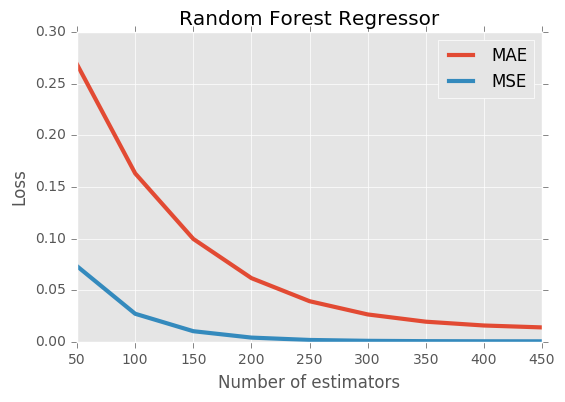

In [21]:
plot_name="Random Forest Regressor"
loss_mae, loss_mse = [], []
print(plot_name)
for est in range(50,500,50):
    print("Number of estimators: %d" % est)
    mae, mse = def_metrics(model.def_xgboost(estimators = est))
    print("MAE: ", mae)
    print("MSE: ", mse)
    loss_mae.append(mae)
    loss_mse.append(mse)
plot_performance(plot_name, loss_mae, loss_mse)

## 4.3 Gradient Boosting Regressor

Gradient Boosting Regressor
Number of estimators: 50
MAE:  0.268556920268
MSE:  0.0732754324612
Number of estimators: 100
MAE:  0.163131052904
MSE:  0.0272683219257
Number of estimators: 150
MAE:  0.0997055884581
MSE:  0.0103993594303
Number of estimators: 200
MAE:  0.061763787024
MSE:  0.00420553552461
Number of estimators: 250
MAE:  0.0394233414477
MSE:  0.00191993745602
Number of estimators: 300
MAE:  0.0266204181821
MSE:  0.00107334558997
Number of estimators: 350
MAE:  0.0196005278404
MSE:  0.000758506898203
Number of estimators: 400
MAE:  0.0159180821829
MSE:  0.000637746477729
Number of estimators: 450
MAE:  0.0140621869606
MSE:  0.000591850428458


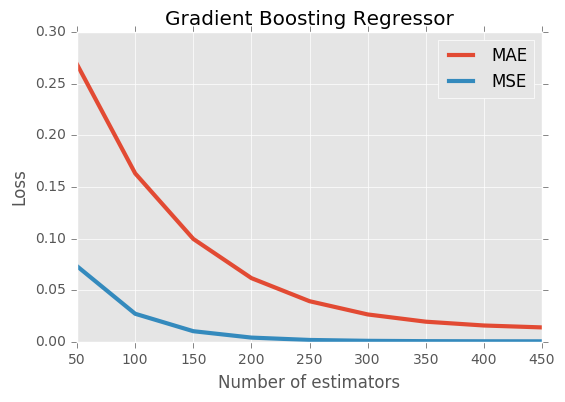

In [22]:
plot_name="Gradient Boosting Regressor"
loss_mae, loss_mse = [], []
print(plot_name)
for est in range(50,500,50):
    print("Number of estimators: %d" % est)
    mae, mse = def_metrics(model.def_xgboost(estimators = est))
    print("MAE: ", mae)
    print("MSE: ", mse)
    loss_mae.append(mae)
    loss_mse.append(mse)
plot_performance(plot_name, loss_mae, loss_mse)

## 4.4 Ada Boost Regressor

Ada Boost Regressor
Number of estimators: 50
MAE:  0.268556920268
MSE:  0.0732754324612
Number of estimators: 100
MAE:  0.163131052904
MSE:  0.0272683219257
Number of estimators: 150
MAE:  0.0997055884581
MSE:  0.0103993594303
Number of estimators: 200
MAE:  0.061763787024
MSE:  0.00420553552461
Number of estimators: 250
MAE:  0.0394233414477
MSE:  0.00191993745602
Number of estimators: 300
MAE:  0.0266204181821
MSE:  0.00107334558997
Number of estimators: 350
MAE:  0.0196005278404
MSE:  0.000758506898203
Number of estimators: 400
MAE:  0.0159180821829
MSE:  0.000637746477729
Number of estimators: 450
MAE:  0.0140621869606
MSE:  0.000591850428458


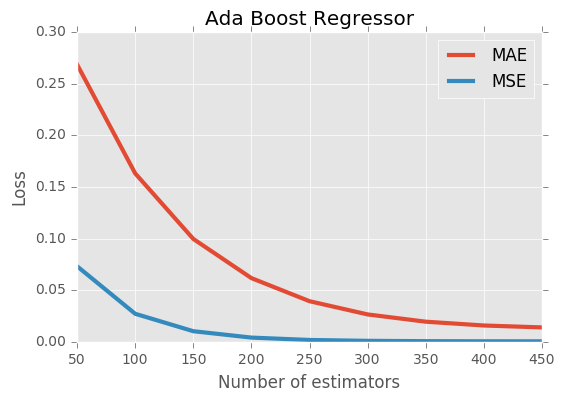

In [23]:
plot_name="Ada Boost Regressor"
loss_mae, loss_mse= [], []
print(plot_name)
for est in range(50,500,50):
    print("Number of estimators: %d" % est)
    mae, mse = def_metrics(model.def_xgboost(estimators = est))
    print("MAE: ", mae)
    print("MSE: ", mse)
    loss_mae.append(mae)
    loss_mse.append(mse)
plot_performance(plot_name, loss_mae, loss_mse)